In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`01_head_direction.ipynb`**. See the button at the top right to download as markdown or pdf.
:::


# Analyzing head-direction cells with Pynapple

<div class="render-all">

In this tutorial, we will learn how to use pynapple to analyze electrophysiological data and calcium imaging data.

1. We will first analyze extracellular recordings of head-direction cells recorded in the 
anterodorsal thalamic nucleus (ADn) of the mouse. We will use a NWB file containing spike times of neurons and the head-direction of the animal over time.
We will study the relationship between neurons during wakefulness and sleep with cross-correlograms.

2. We will then analyze calcium imaging data of head-direction cells recorded in the postsubiculum of the mouse.
We will use a NWB file containing deconvolved calcium events of neurons and the head-direction of the animal over time.
We will study the tuning properties of neurons with tuning curves.


The pynapple documentation can be found [here](https://pynapple.org).

The nemos documentation can be found [here](https://nemos.readthedocs.io/en/latest/).


</div>

## Part 1. Analyzing extracellular recordings of head-direction cells

<div class="render-all">

For part 1 of the tutorial, we will use pynapple to do the following tasks:
1. Loading a NWB file
2. Compute tuning curves
3. Compute cross-correlograms

Let's start by importing all the packages.

</div>

In [2]:
import pynapple as nap
import matplotlib.pyplot as plt
import numpy as np
import nemos as nmo

# some helper plotting functions
import workshop_utils

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

# configure plots some
plt.style.use(nmo.styles.plot_style)

### Fetch and load data

<div class="render-all">

The dataset we will use is from this study : [Peyrache et al., 2015](https://www.nature.com/articles/nn.3968).

If you ran the workshop setup script, you should have this file downloaded already. 
If not, the function we'll use to fetch it will download it for you. 
This function is called `fetch_data`, and can be imported from the `workshop_utils` module. 
This function will give us the file path to where the data is stored. 

</div>

In [3]:
path = workshop_utils.fetch_data("Mouse32-140822.nwb")

print(path)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/data/Mouse32-140822.nwb


<div class="render-all">

Pynapple provides the convenience function `nap.load_file` for loading a NWB file.

**Question:** Can you open the NWB file giving the variable `path` to the function `load_file` and call the output `data`?

</div>

<div class="render-user">
```{code-cell} ipython3
data =
print(data)
```
</div>

In [4]:
data = nap.load_file(path)

print(data)

Mouse32-140822
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                 │ TsGroup     │
│ sws                   │ IntervalSet │
│ rem                   │ IntervalSet │
│ position_time_support │ IntervalSet │
│ epochs                │ IntervalSet │
│ ry                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


<div class="render-all">

The content of the NWB file is not loaded yet. The object `data` behaves like a dictionary.
It contains multiple entries corresponding to different data types stored in the NWB file.
In NWB files, spike times are stored in the `units` entry.

**Question:** Can you load the spike times from the NWB and call the variables `spikes`?

</div>

<div class="render-user">
```{code-cell} ipython3
spikes =   # Get spike timings
print(spikes)
```
</div>

In [5]:
spikes = data["units"]  # Get spike timings
print(spikes)

Index    rate     location    group
-------  -------  ----------  -------
0        2.96981  thalamus    1
1        2.42638  thalamus    1
2        5.93417  thalamus    1
3        5.04432  thalamus    1
4        0.30207  adn         2
5        0.87042  adn         2
6        0.36154  adn         2
...      ...      ...         ...
42       1.02061  thalamus    5
43       6.84913  thalamus    6
44       0.94002  thalamus    6
45       0.55768  thalamus    6
46       1.15056  thalamus    6
47       0.46084  thalamus    6
48       0.19287  thalamus    7


<div class="render-all">

There are a lot of neurons. The neurons that interest us are the neurons labeled `adn`. 

**Question:** Using the slicing method of your choice, can you select only the neurons in `adn` that are above 2 Hz firing rate?

THere multiple options here. As a reminder, metadatas can be accessed like a dictionary or as attributes. There are also
functions that can help you filter neurons based on metadata.

1. `spikes.label` returns a pandas Series with the metadata of the neurons.
2. `spikes['label']` returns a pandas Series with the metadata of the neurons.
3. Functions like [`spikes.getby_category`](https://pynapple.org/generated/pynapple.TsGroup.getby_category.html#pynapple.TsGroup.getby_category)
    or [`spikes.getby_threshold`](https://pynapple.org/generated/pynapple.TsGroup.getby_threshold.html#pynapple.TsGroup.getby_threshold) can help you filter neurons based on metadata.

</div>

<div class="render-user">
```{code-cell} ipython3
spikes =   # Select only ADN neurons with rate > 2.0 Hz
print(len(spikes))
```
</div>

In [6]:
spikes = spikes[(spikes.location=='adn') & (spikes.rate>2.0)]

print(len(spikes))

18


<div class="render-all">

The NWB file contains other information about the recording. `ry` contains the value of the head-direction of the animal over time. 

**Question:** Can you extract the angle of the animal in a variable called `angle` and print it?

</div>

<div class="render-user">
```{code-cell} ipython3
angle =   # Get head-direction data from NWB object
print(angle)
```
</div>

In [7]:
angle = data["ry"]
print(angle)

Time (s)
----------  --------
8812.416    0.581795
8812.4416   0.578113
8812.4672   0.571791
8812.4928   0.554532
8812.5184   0.554532
8812.544    0.554532
8812.5696   0.554532
...
10771.123   5.67668
10771.149   5.67668
10771.174   5.7182
10771.2     5.74727
10771.226   5.74727
10771.251   5.74727
10771.277   5.72318
dtype: float64, shape: (71478,)


<div class="render-all">

But are the data actually loaded or not?
If you look at the type of `angle`, you will see that it is a `Tsd` object.
But what about the underlying data array?
The underlying data array is stored in the property `d` of the `Tsd` object.
If you print it, you will see that it is a `h5py` array.
By default, data are lazy-loaded. This can be useful when reading larger than memory array from disk with memory map.

</div>

In [8]:
print(angle.d)

<HDF5 dataset "data": shape (71478,), type "<f8">


<div class="render-all">

The animal was recorded during wakefulness and sleep. 

**Question:** Can you extract the behavioral intervals in a variable called `epochs`?

</div>

<div class="render-user">
```{code-cell} ipython3
epochs =   # Get behavioral epochs from NWB object
print(epochs)
```
</div>

In [9]:
epochs = data["epochs"]

print(epochs)

  index    start      end  tags
      0      0     8812.3  sleep
      1   8812.3  10771.3  wake
      2  10771.3  22025    sleep
shape: (3, 2), time unit: sec.


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: DataFrame is not sorted by start times. Sorting it.
  data = nap.IntervalSet(df)


<div class="render-all">

NWB file can save intervals with multiple labels. The object `IntervalSet` includes the labels as a metadata object.

**Question:** Using the column `tags`, can you create one `IntervalSet` object for intervals labeled `wake` and one `IntervalSet` object for intervals labeled `sleep`?

</div>

<div class="render-user">
```{code-cell} ipython3
wake_ep =  # Get wake intervals from epochs
sleep_ep =  # Get sleep intervals from epochs
```
</div>

In [10]:
wake_ep = epochs[epochs.tags=="wake"]
sleep_ep = epochs[epochs.tags=="sleep"]

### Compute tuning curves

<div class="render-all">

Now we have 
- spikes
- a behavioral feature (i.e. head-direction), 
- epochs corresponding to when the feature is defined (i.e. when the head-direction was recorded).

We can compute tuning curves, i.e. the firing rate of neurons as a function of head-direction. 
We want to know how the firing rate of each neuron changes as a function of the head-direction of the animal during wakefulness.

To do this in pynapple, all you need is the call of a single function : `nap.compute_tuning_curves`!

**Question:** can you compute the firing rate of ADn units as a function of heading direction, i.e. a head-direction tuning curve and call the variable `tuning_curves`?

</div>

<div class="render-user">
```{code-cell} ipython3
tuning_curves = nap.compute_tuning_curves(
    data=, # The neural activity as a TsGroup
    features=, # Which feature? Here the head-direction of the animal
    bins=, # How many bins of feature space? Here 61 angular bins is a good numbers
    epochs = angle.time_support, # The epochs should correspond to when the features are defined. Here we use the time support directly
    range= (0, 2*np.pi), # The min and max of the bin array
    feature_names = ["angle"] # Let's give a name to our feature for better labelling of the output.
    ) 
tuning_curves
```
</div>

In [11]:
tuning_curves = nap.compute_tuning_curves(
    data=spikes,
    features=angle, 
    bins=61, 
    epochs = angle.time_support,
    range=(0, 2 * np.pi),
    feature_names = ["angle"]
    )

tuning_curves

<xarray.DataArray (unit: 18, angle: 61)> Size: 9kB
array([[ 5.3160055 ,  8.30492549, 11.86764801, ...,  1.93672712,
         2.15290985,  2.504815  ],
       [ 0.        ,  0.03757885,  0.15823531, ...,  0.53330167,
         0.22081127,  0.        ],
       [ 0.72297675,  0.33820964,  0.09494118, ...,  0.22454807,
         0.38641972,  0.30463966],
       ...,
       [ 0.29769631,  0.37578848,  0.34811768, ...,  0.11227404,
         0.02760141,  0.10154655],
       [ 0.85056088,  0.75157697,  1.07600009, ...,  1.03853483,
         0.93844788,  0.81237243],
       [ 5.27347746,  8.38008318, 10.50682437, ...,  0.95432931,
         1.02125211,  2.23402419]], shape=(18, 61))
Coordinates:
  * unit     (unit) int64 144B 7 8 9 10 13 14 17 18 ... 21 22 24 25 26 29 30 33
  * angle    (angle) float64 488B 0.0515 0.1545 0.2575 ... 6.026 6.129 6.232
Attributes:
    occupancy:  [ 858.  971. 1153. 1392. 1307.  978.  945.  969.  983.  898. ...
    bin_edges:  [array([0.        , 0.10300304, 0.20600608, 0.30900911, 0.412...
    fs:         36.48906175578562
    rates:      [ 8.12564036  0.70295953  2.09866856  8.20425747  3.73227095 ...

<div class="render-all">

The output is a xarray object indexed by neuron and head\-direction: the first dimension corresponds to neurons, 
the second to angular bins, and additional metadata fields are included.

</div>

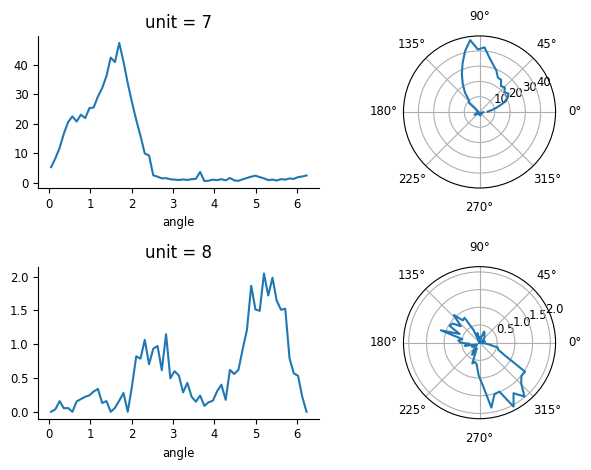

In [12]:
fig = plt.figure()
plt.subplot(221)
tuning_curves[0].plot()
# plt.plot(tuning_curves[0])
plt.subplot(222,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[0].values)
plt.subplot(223)
tuning_curves[1].plot()
plt.subplot(224,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[1].values)
plt.tight_layout()

In [13]:
fig.savefig("../../_static/_check_figs/01-00.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-00.png)
:::
</div>


<div class="render-all">

Most of those neurons are head-directions neurons.

The next cell allows us to get a quick estimate of the neurons's preferred direction. 
Since this is a lot of xarray wrangling, it is given.

</div>

In [14]:
pref_ang = tuning_curves.idxmax(dim="angle")

print(pref_ang)

<xarray.DataArray 'angle' (unit: 18)> Size: 144B
array([1.69955012, 5.20165341, 2.21456531, 4.17162303, 0.97852886,
       0.56651671, 4.17162303, 3.45060177, 4.78964126, 0.97852886,
       1.69955012, 3.96561696, 4.58363518, 2.7295805 , 5.20165341,
       3.03858962, 4.27462607, 3.65660784])
Coordinates:
  * unit     (unit) int64 144B 7 8 9 10 13 14 17 18 ... 21 22 24 25 26 29 30 33
Attributes:
    occupancy:  [ 858.  971. 1153. 1392. 1307.  978.  945.  969.  983.  898. ...
    bin_edges:  [array([0.        , 0.10300304, 0.20600608, 0.30900911, 0.412...
    fs:         36.48906175578562
    rates:      [ 8.12564036  0.70295953  2.09866856  8.20425747  3.73227095 ...


<div class="render-all">

The variable `pref_ang` contains the preferred direction of each neuron. 
Now this information can be useful to add it to the metainformation of the `spikes` object since it is neuron-specific information.

**Question:** Can you add it to the metainformation of `spikes`? The metadata field should be called `pref_ang`.

Hint :

There are multiple ways of doing this:
```
tsgroup['label'] = metadata
tsgroup.label = metadata
tsgroup.set_info(label=metadata)
```

</div>

In [15]:
# spikes['pref_ang'] = pref_ang
spikes.set_info(pref_ang = pref_ang)

spikes

Index    rate      location    group    pref_ang
-------  --------  ----------  -------  ----------
7        10.51737  adn         2        1.7
8        2.62475   adn         2        5.2
9        2.55818   adn         2        2.21
10       7.06715   adn         2        4.17
13       4.87837   adn         2        0.98
14       8.47337   adn         2        0.57
17       6.1304    adn         3        4.17
...      ...       ...         ...      ...
22       9.71401   adn         3        3.97
24       19.65395  adn         3        4.58
25       3.87855   adn         3        2.73
26       4.0242    adn         3        5.2
29       4.23006   adn         4        3.04
30       2.15215   adn         4        4.27
33       5.26316   adn         4        3.66

<div class="render-all">

This index maps a neuron to a preferred angular direction between 0 and 2pi. 
Let's visualize the spiking activity of the neurons based on their preferred direction 
as well as the head-direction of the animal. To make it easier to see, we will restrict the data to a small epoch.

</div>

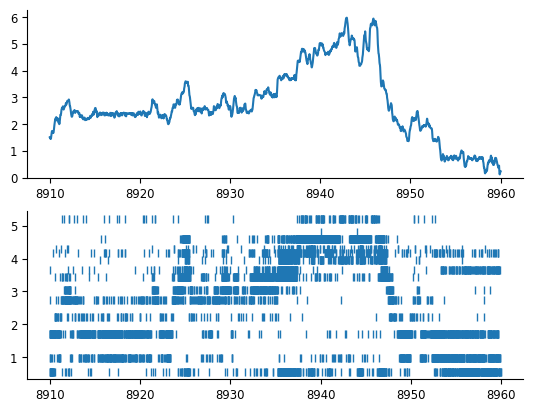

In [16]:
ex_ep = nap.IntervalSet(start=8910, end=8960)

fig = plt.figure()
plt.subplot(211)
plt.plot(angle.restrict(ex_ep))
plt.ylim(0, 2*np.pi)

plt.subplot(212)
plt.plot(spikes.restrict(ex_ep).to_tsd("pref_ang"), '|')

In [17]:
fig.savefig("../../_static/_check_figs/01-01.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-01.png)
:::
</div>

### Compute correlograms

<div class="render-all">

We see that some neurons have a correlated activity meaning they tend to fire together, while others have an anti-correlated activity meaning when one neuron fires, the other does not.
Can we quantify this correlation between pairs of neurons? To do this, we can compute cross-correlograms between pairs of neurons.
A cross-correlogram measures the correlation between the spike trains of two neurons as a function of time lag. It counts how often spikes from one neuron occur at different time lags relative to spikes from another neuron.
In pynapple, we use the function `nap.compute_crosscorrelogram` to compute cross-correlograms between pairs of neurons.

**Question:** Can you compute cross-correlograms during wake for all pairs of neurons and call it `cc_wake`?

</div>

<div class="render-user">
```{code-cell} ipython3
cc_wake = nap.compute_crosscorrelogram(
    group=, # The neural activity as a TsGroup
    binsize=, # I suggest 200 ms bin
    windowsize=, # Let's do a 20 s window
    ep= # Which epoch to restrict the cross-correlograms. Here is it should be wakefulness.
    )
```
</div>

In [18]:
cc_wake = nap.compute_crosscorrelogram(spikes, binsize=0.2, windowsize=20.0, ep=wake_ep)

<div class="render-all">

The output is a pandas DataFrame where each column is a pair of neurons. All pairs of neurons are computed automatically.
The index shows the time lag.
Let's visualize some cross-correlograms. 
To make things easier, we will focus on two pairs of neurons: one pair that fires for the same direction and one pair that fires for opposite directions.

The pair (7, 20) fires for the same direction while the pair (7, 26) fires for opposite directions. 

To index pandas columns, you can do `cc[(7, 20)]`.

To index xarray tuning curves, you can do `tuning_curves.sel(unit=[7,20])`

</div>

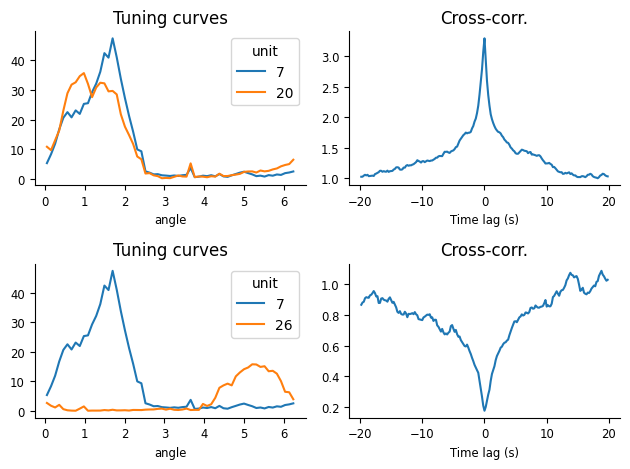

In [19]:
index = spikes.keys()


fig = plt.figure()
plt.subplot(221)
tuning_curves.sel(unit=[7,20]).plot(x='angle', hue='unit')
plt.title("Tuning curves")
plt.subplot(222)
plt.plot(cc_wake[(7, 20)])
plt.xlabel("Time lag (s)")
plt.title("Cross-corr.")
plt.subplot(223)
tuning_curves.sel(unit=[7,26]).plot(x='angle', hue='unit')
plt.title("Tuning curves")
plt.subplot(224)
plt.plot(cc_wake[(7, 26)])
plt.xlabel("Time lag (s)")
plt.title("Cross-corr.")
plt.tight_layout()

In [20]:
fig.savefig("../../_static/_check_figs/01-02.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-02.png)
:::
</div>


<div class="render-all">

As you can see, the pair of neurons that fire for the same direction have a positive correlation at time lag 0, meaning they tend to fire together.
The pair of neurons that fire for opposite directions have a negative correlation at time lag 0, meaning when one neuron fires, the other does not.

Pairwise correlation were computed during wakefulness. The activity of the neurons was also recorded during sleep.

**Question:** can you compute the cross-correlograms during sleep?

</div>

<div class="render-user">
```{code-cell} ipython3
cc_sleep = nap.compute_crosscorrelogram(
    group=, # The neural activity as a TsGroup
    binsize=, # I suggest 20 ms bin
    windowsize=, # Let's do a 1 s window
    ep= # Which epoch to restrict the cross-correlograms. Here is it should be sleep.
    )
```
</div>

In [21]:
cc_sleep = nap.compute_crosscorrelogram(spikes, 0.02, 1.0, ep=sleep_ep)

<div class="render-all">

Let's visualize the cross-correlograms during wake and sleep for the pair of neurons that fire for the same direction 
and the pair of neurons that fire for opposite directions.

</div>

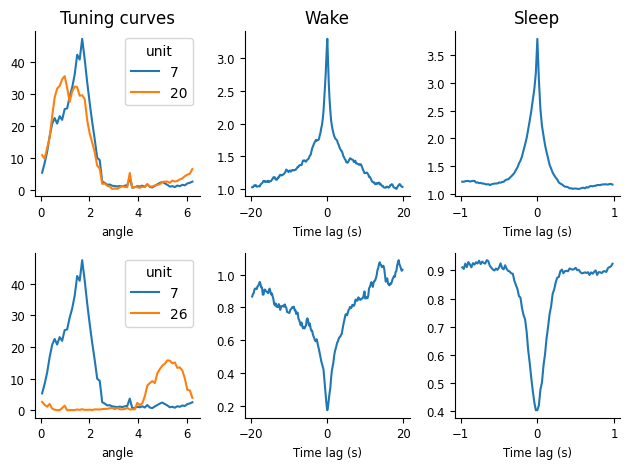

In [22]:
fig = plt.figure()
plt.subplot(231)
tuning_curves.sel(unit=[7,20]).plot(x='angle', hue='unit')
plt.title("Tuning curves")
plt.subplot(232)
plt.plot(cc_wake[(7, 20)])
plt.xlabel("Time lag (s)")
plt.title("Wake")
plt.subplot(233)
plt.plot(cc_sleep[(7, 20)])
plt.xlabel("Time lag (s)")
plt.title("Sleep")
plt.subplot(234)
tuning_curves.sel(unit=[7,26]).plot(x='angle', hue='unit')
plt.subplot(235)
plt.plot(cc_wake[(7, 26)])
plt.xlabel("Time lag (s)")
plt.subplot(236)
plt.plot(cc_sleep[(7, 26)])
plt.xlabel("Time lag (s)")
plt.tight_layout()

In [23]:
fig.savefig("../../_static/_check_figs/01-03.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-03.png)
:::
</div>

<div class="render-all">

What does it mean for the relationship between cells here? Remember that during sleep, the animal is not moving and therefore the head-direction is not defined.

</div>


## Part 2. Analyzing calcium imaging recordings of head-direction cells

<div class="render-all">

For part 2 of the tutorial, we will use pynapple to do the following tasks:
1. Loading a NWB file
2. Compute tuning curves
3. Visualize tuning curves
4. Decode head-direction from neural activity

</div>

In [24]:
path = nmo.fetch.fetch_data("A0670-221213.nwb")
print(path)

  0%|                                              | 0.00/75.2M [00:00<?, ?B/s]

  1%|▏                                     | 441k/75.2M [00:00<00:17, 4.39MB/s]

  8%|███                                  | 6.26M/75.2M [00:00<00:01, 36.0MB/s]

 20%|███████▎                             | 15.0M/75.2M [00:00<00:01, 59.3MB/s]

 32%|███████████▊                         | 23.9M/75.2M [00:00<00:00, 71.2MB/s]

 43%|███████████████▊                     | 32.3M/75.2M [00:00<00:00, 75.6MB/s]

 54%|████████████████████                 | 40.7M/75.2M [00:00<00:00, 78.5MB/s]

 64%|███████████████████████▊             | 48.5M/75.2M [00:00<00:00, 78.0MB/s]

 76%|████████████████████████████▎        | 57.4M/75.2M [00:00<00:00, 81.6MB/s]

 88%|████████████████████████████████▋    | 66.4M/75.2M [00:00<00:00, 84.1MB/s]

  0%|                                              | 0.00/75.2M [00:00<?, ?B/s]

100%|██████████████████████████████████████| 75.2M/75.2M [00:00<00:00, 158GB/s]

/home/agent/workspace/rorse_ccn-software-feb-2026_main/data/A0670-221213.nwb


### Load data

<div class="render-all">

Similar to part 1, we will start by loading the NWB file. The function `nap.load_file` can be used again.

</div>

<div class="render-user">
```{code-cell} ipython3
data = ... # Load NWB file
print(data)
```
</div>

In [25]:
data = nap.load_file(path)

print(data)

A0670-221213
┍━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                  │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ position_time_support │ IntervalSet │
│ RoiResponseSeries     │ TsdFrame    │
│ z                     │ Tsd         │
│ y                     │ Tsd         │
│ x                     │ Tsd         │
│ rz                    │ Tsd         │
│ ry                    │ Tsd         │
│ rx                    │ Tsd         │
┕━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


<div class="render-all">

There are multiple entries in the NWB file. The calcium transients are stored in the `RoiResponseSeries` entry.
The head-direction of the animal is stored in the `ry` entry. Let's extract them.

</div>

In [26]:
transients = data["RoiResponseSeries"]
angle = data["ry"]
print(transients)

Time (s)          0        1         2         3         4  ...
----------  -------  -------  --------  --------  --------  -----
3.1187      0.27546  0.79973  0.16383   0.20118   0.029255  ...
3.15225     0.26665  0.86751  0.15879   0.23682   0.027189  ...
3.18585     0.25796  0.89419  0.15352   0.25074   0.036514  ...
3.2194      0.24943  0.89513  0.14812   0.25215   0.056273  ...
3.253       0.24111  0.88023  0.14898   0.24651   0.070954  ...
3.28655     0.233    0.85584  0.14858   0.23706   0.081469  ...
3.32015     0.22513  1.0996   0.14715   0.22572   0.088588  ...
...                                                         ...
1203.38945  0.20815  0.17535  0.12126   0.094461  0.87427   ...
1203.42305  0.20247  0.17243  0.11807   0.089918  1.2578    ...
1203.4566   0.19654  0.17056  0.11461   0.085079  1.62      ...
1203.4902   0.19052  0.16645  0.11096   0.080197  1.8811    ...
1203.52375  0.18449  0.16105  0.10717   0.075416  2.0599    ...
1203.55735  0.17851  0.15494  0.10331 

<div class="render-all">

To get an idea of the data, let's visualize the calcium transients of the first two neurons for the first 100 seconds of the recording.
Instead of creating a new `IntervalSet` object, we can use the method `transients.get(0, 100)` to get a restricted version of the `Tsd` object.
Contrary to `restrict`, which takes an `IntervalSet` object as input, `get` can take start and end times directly as input and does not 
update the time support of the output `Tsd` object.

</div>

Text(0, 0.5, 'Fluorescence (a.u.)')

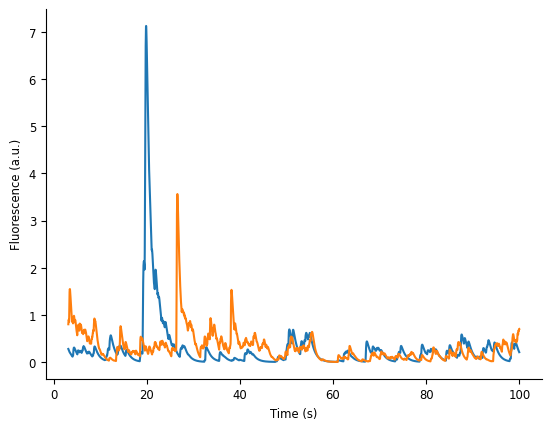

In [27]:
fig = plt.figure()
plt.plot(transients[:,0:2].get(0, 100))
plt.xlabel("Time (s)")
plt.ylabel("Fluorescence (a.u.)")

In [28]:
fig.savefig("../../_static/_check_figs/01-04.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-04.png)
:::
</div>

### Compute tuning curves

<div class="render-all">

Now we have 
- calcium transients
- a behavioral feature (i.e. head-direction),
We can compute tuning curves, i.e. the fluorescence of neurons as a function of head-direction. 
We want to know how the fluorescence of each neuron changes as a function of the head-direction of the animal.
We can use the same function as before : `nap.compute_tuning_curves`. 
Don't forget to give a name to the feature when calling the function (i.e. `feature_names = ["angle"]`).

</div>

<div class="render-user">
```{code-cell} ipython3
tuning_curves = nap.compute_tuning_curves(
    data=, # The neural activity as a TsGroup
    features=, # Which feature? Here the head-direction of the animal
    bins=, # How many bins of feature space? Here 61 angular bins is a good numbers 
    range=, # The min and max of the bin array
    feature_names =  # Let's give a name to our feature for better labelling of the output.
    ) 
tuning_curves
```
</div>

In [29]:
tuning_curves = nap.compute_tuning_curves(
    data=transients,
    features=angle, 
    bins=61, 
    epochs = angle.time_support,
    range=(0, 2 * np.pi),
    feature_names = ["angle"]
    )
tuning_curves

<xarray.DataArray (unit: 65, angle: 61)> Size: 32kB
array([[0.336294  , 0.39249376, 0.28825878, ..., 0.36234269, 0.2708909 ,
        0.28310301],
       [0.05395929, 0.04359246, 0.04214995, ..., 0.07306646, 0.06231189,
        0.05681652],
       [0.15342062, 0.17939499, 0.15450186, ..., 0.1853742 , 0.11779423,
        0.12548764],
       ...,
       [0.09231561, 0.09080612, 0.06466286, ..., 0.13556026, 0.1133827 ,
        0.09577019],
       [0.10206325, 0.08374734, 0.07383455, ..., 0.11335814, 0.10032206,
        0.09266054],
       [0.09586888, 0.13690644, 0.16440948, ..., 0.0797701 , 0.08365685,
        0.0929572 ]], shape=(65, 61))
Coordinates:
  * unit     (unit) int64 520B 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63 64
  * angle    (angle) float64 488B 0.0515 0.1545 0.2575 ... 6.026 6.129 6.232
Attributes:
    occupancy:  [1898. 2249. 2064. 1962. 2081. 2249. 2544. 2511. 2045. 2498. ...
    bin_edges:  [array([0.        , 0.10300304, 0.20600608, 0.30900911, 0.412...
    fs:         120.00514660424693

### Visualize tuning curves

Let's visualize the tuning curves of the first two neurons.

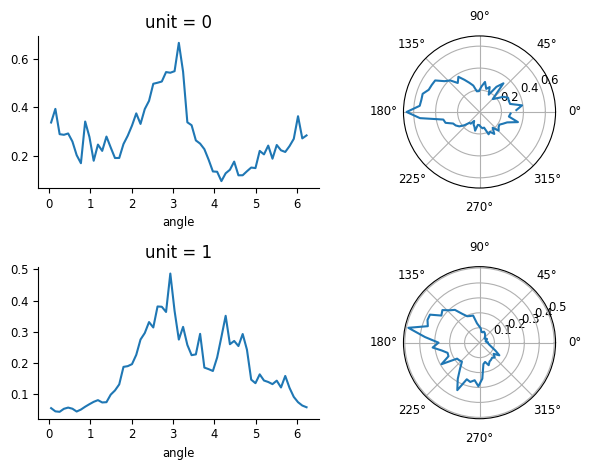

In [30]:
fig = plt.figure()
plt.subplot(221)
tuning_curves[0].plot()
plt.subplot(222,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[0].values)
plt.subplot(223)
tuning_curves[1].plot()
plt.subplot(224,projection='polar')
plt.plot(tuning_curves.angle, tuning_curves[1].values)
plt.tight_layout()

In [31]:
fig.savefig("../../_static/_check_figs/01-05.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-05.png)
:::
</div>



### Decode head-direction from neural activity

<div class="render-all">

Now that we have the tuning curves, we can use them to decode the head-direction of the animal from the neural activity.
Pynapple provides two functions to do this: `nap.decode_bayes` for spike counts and `nap.decode_template` for event rates or continuous data. 
Since the data are calcium transients and not spike counts, we will use the template matching method.

**Question:** Can you decode the head-direction of the animal using the function `nap.decode_template` and call the variable `decoded_angle`?

We will us the epoch `epochs = nap.IntervalSet([50, 150])` to restrict the decoding to the first 100 seconds of the recording.

</div>

<div class="render-user">
```{code-cell} ipython3
epochs = nap.IntervalSet(start=50, end=150)
decoded_angle, dist = nap.decode_template(
    tuning_curves=..., # The tuning curves as an xarray object
    data=..., # The neural activity as a TsdFrame in this case
    bin_size=..., # The bin size for decoding. Here I suggest 0.1 second
    metric=... # The metric to use to compare the neural activity to the tuning curves. Here I suggest "correlation"
    epochs=transients.time_support # The epochs should correspond to when the neural activity is defined. Here we use the time support directly
    )
```
</div>

In [32]:
epochs = nap.IntervalSet(start=50, end=150)
decoded_angle, dist = nap.decode_template(
    tuning_curves=tuning_curves,
    data=transients,
    bin_size=0.1,
    metric="correlation",
    epochs=epochs    
    )

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/pynapple/process/decoding.py:48: UserWarning: passed bin_size is different from actual data bin size.
  warnings.warn("passed bin_size is different from actual data bin size.")


<div class="render-all">
Let's visualize the decoded head-direction of the animal for the first 100 seconds of the recording.
</div>

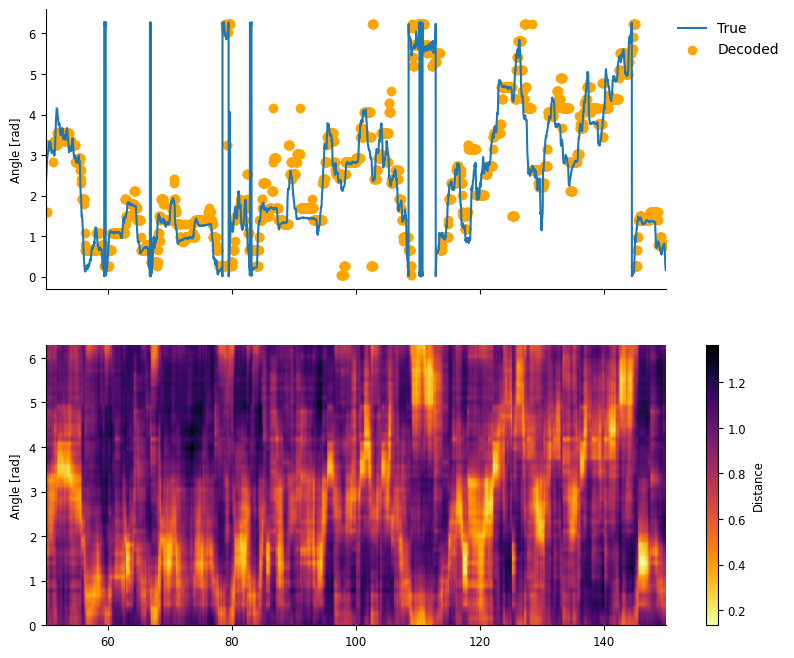

In [33]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), nrows=2, ncols=1, sharex=True)
ax1.plot(angle.restrict(epochs), label="True")
ax1.scatter(decoded_angle.times(), decoded_angle.values, label="Decoded", c="orange")
ax1.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel("Angle [rad]")

im = ax2.imshow(
    dist.values.T, 
    aspect="auto", 
    origin="lower", 
    cmap="inferno_r", 
    extent=(epochs.start[0], epochs.end[0], 0.0, 2*np.pi)
)
ax2.set_ylabel("Angle [rad]")
cbar_ax2 = fig.add_axes([0.95, ax2.get_position().y0, 0.015, ax2.get_position().height])
fig.colorbar(im, cax=cbar_ax2, label="Distance")


In [34]:
fig.savefig("../../_static/_check_figs/01-06.png")

<div class="render-user">
:::{admonition} Figure check
:class: dropdown
![](../../_static/_check_figs/01-06.png)
:::
</div>


<div class="render-all">

The first panel shows the true head-direction of the animal and the decoded head-direction from neural activity.
The second panel shows the distance between the neural activity and the tuning curves as a function of time and angle.

You can play with the metric parameters of the decoding function to see how it affects the decoding performance. 
Possible metrics are "euclidean", "manhattan", "correlation", "jensenshannon" and "cosine". 

</div>